In [1]:
import sys, re
from pathlib import Path
home = str(Path.home())
sys.path.append(home+'/ccount/ccount/workflow/scripts/')
sys.path.append(home+'/ccount/ccount/workflow/scripts/ccount/')
from os.path import exists

from ccount.blob.io import load_locs, save_crops, load_crops
from ccount.blob.misc import crops_stat
from ccount.clas.pca_tsne import pca_tsne

from ccount.img.read_czi import read_czi, parse_image_obj
from ccount.blob.crop_blobs import crop_blobs
from ccount.blob.plot import plot_flat_crop, plot_flat_crops, pop_label_flat_crops, show_rand_crops

import numpy as np
import pandas as pd
import subprocess

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

/home/socolovsky_lab/mambaforge/envs/ccount-env/lib/python3.8/site-packages/scipy/__init__.py:143: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/socolovsky_lab/mambaforge/envs/ccount-env/lib/python3.8/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
# show file names of all blobs that needs to be labeled
%ls ./res/classification1/pos/
%ls ./data/

S0A1_FIRST_SCAN-Stitching-24.0.crops.clas.npy.gz*
S0A1_FIRST_SCAN-Stitching-24.1.crops.clas.npy.gz*
S0A1_FIRST_SCAN-Stitching-24.2.crops.clas.npy.gz*
S0A1_FIRST_SCAN-Stitching-24.3.crops.clas.npy.gz*
S0A1_SECOND_SCAN-Stitching-23.0.crops.clas.npy.gz*
S0A1_SECOND_SCAN-Stitching-23.1.crops.clas.npy.gz*
S0A1_SECOND_SCAN-Stitching-23.2.crops.clas.npy.gz*
S0A1_SECOND_SCAN-Stitching-23.3.crops.clas.npy.gz*
S0A2_FIRST_SCAN-Stitching-22.0.crops.clas.npy.gz*
S0A2_FIRST_SCAN-Stitching-22.1.crops.clas.npy.gz*
S0A2_FIRST_SCAN-Stitching-22.2.crops.clas.npy.gz*
S0A2_FIRST_SCAN-Stitching-22.3.crops.clas.npy.gz*
S0A2_SECOND_SCAN-Stitching-21.0.crops.clas.npy.gz*
S0A2_SECOND_SCAN-Stitching-21.1.crops.clas.npy.gz*
S0A2_SECOND_SCAN-Stitching-21.2.crops.clas.npy.gz*
S0A2_SECOND_SCAN-Stitching-21.3.crops.clas.npy.gz*
S0A3_FIRST_SCAN-Stitching-20.0.crops.clas.npy.gz*
S0A3_FIRST_SCAN-Stitching-20.1.crops.clas.npy.gz*
S0A3_FIRST_SCAN-Stitching-20.2.crops.clas.npy.gz*
S0A3_FIRST_SCAN-Stitching-20.3.crops.clas.

# User Parameters

In [17]:
name = 'S0A1_FIRST_SCAN-Stitching-24.2'  # core name of npy.gz file, which is used to auto generate loc/czi names, and output names

match = re.search(r'(\.)(\d+)$', name)
if match:
    plate_name = name[:match.start()]
    image_index = match.group(2)
    print("plate_name:", plate_name)
    print("image_index:", image_index)
else:
    # No match found, handle accordingly
    print("No match found")
    
czi_name = plate_name + '.czi'
czi_file = './data/' + czi_name
print('czi_file:', czi_file, exists(czi_file))

loc_file = './res/classification1/pos/' + name + '.crops.clas.npy.gz'  
print('loc_file:', loc_file, exists(loc_file))

out_name = name + '.labeled.npy.gz'

plate_name: S0A1_FIRST_SCAN-Stitching-24
image_index: 2
czi_file: ./data/S0A1_FIRST_SCAN-Stitching-24.czi True
loc_file: ./res/classification1/pos/S0A1_FIRST_SCAN-Stitching-24.2.crops.clas.npy.gz True


# Read Data

In [9]:
locs = load_locs(loc_file)  # contains y,x,r in the first 3 columns
locs = locs[0:500, :]
print('only top 500 blobs kept', locs.shape)

./res/classification1/pos/S0A1_FIRST_SCAN-Stitching-24.2.crops.clas.npy.gz (35, 25606)
only top 500 blobs kept (35, 25606)


In [10]:
czi = read_czi(czi_file)  # image array of 4 scanned areas
image = parse_image_obj(czi, i=image_index)  # one of the scanned areas, takes 30s to load
czi=[] # release RAM
# np.save("image.npy", image)  # save temp file for quick reload
# image = np.load('image.npy')

read_czi: ./data/S0A1_FIRST_SCAN-Stitching-24.czi
Format 2019


# View Data
Tip: you can run this many many times to pre-view blobs, and generate your baseline of classification, before you start labeling

showing blob 8


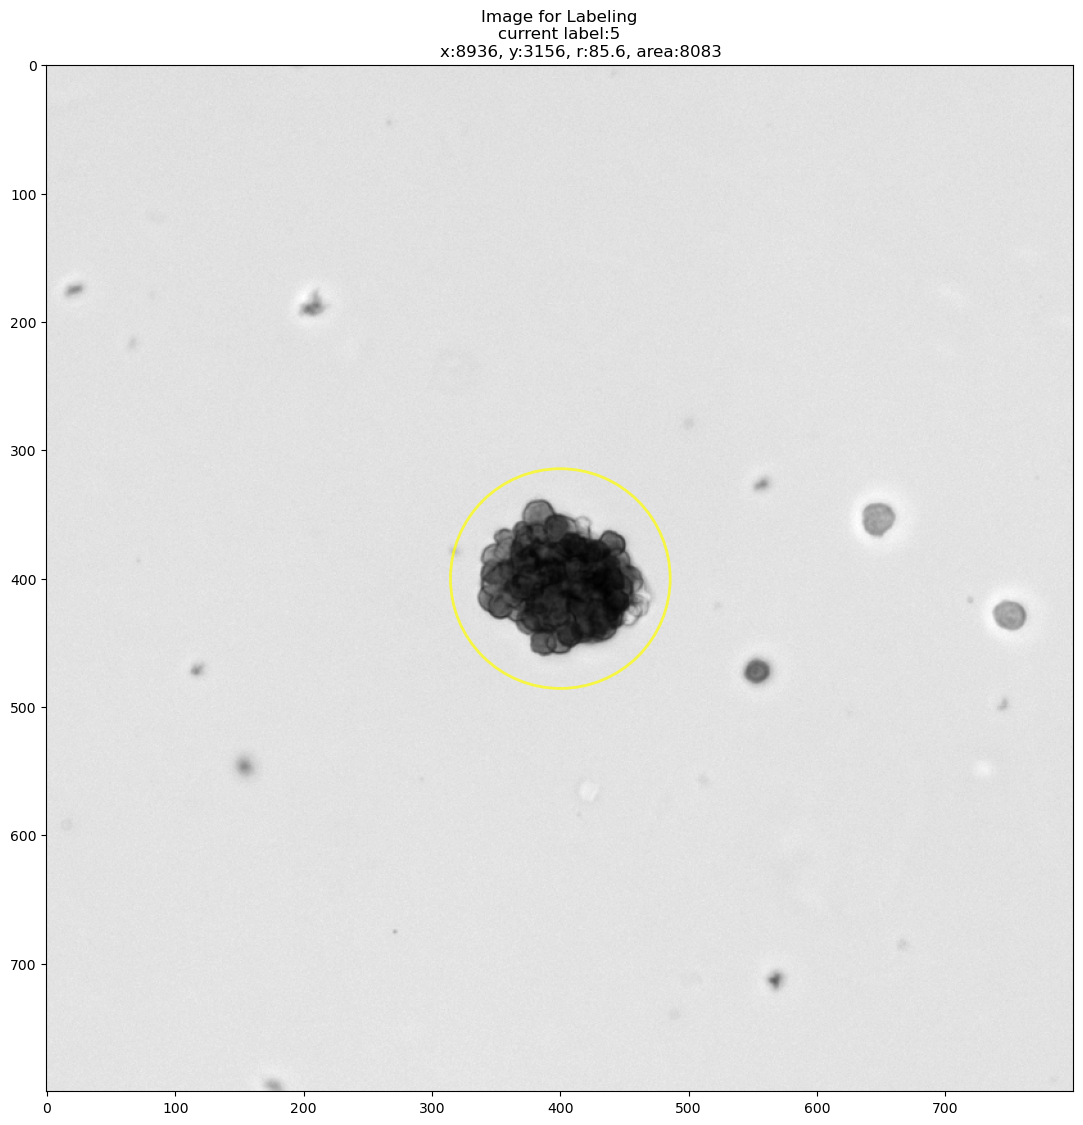

In [11]:
i = np.random.choice(len(locs))
print('showing blob {}'.format(i))

crops = crop_blobs(locs[i:i+1], image, crop_width=400)  # User can change crop_width, 500 for overview
p = plot_flat_crop(crops[0, :],  image_scale=1)

## Labeling


In [14]:
crops = crop_blobs(locs, image, crop_width=100) # can take 30s

In [15]:
# label options: 
# Yes: 1
# No: 0
# Uncertain: 3
# Artifacts: 4
# system reserved: 5 for unlabeled

crops = pop_label_flat_crops(crops, random = True, seed = 1, skip_labels = [0, 1])

## Save

In [18]:
# decide output name and save
locs[:, 3] = crops[:, 3]
s = input ("would you like to save/over-write {} ? (y/n)".format(out_name))
if s == 'y':
    save_crops(locs, out_name)
else:
    print('exit without saving')

would you like to save/over-write S0A1_FIRST_SCAN-Stitching-24.2.labeled.npy.gz ? (y/n) y


Saving S0A1_FIRST_SCAN-Stitching-24.2.labeled.npy.gz
5 Yes, 30 No, 0 Uncertain, 0 Unlabeled
Total: 35
crops dim: (35, 25606)
crop width: 80


# Review Labeled DB (Optional)

In [19]:
labeled = load_crops(out_name)

Reading S0A1_FIRST_SCAN-Stitching-24.2.labeled.npy.gz
n-crop: 35, crop width: 80
5 Yes, 30 No, 0 Uncertain, 0 Unlabeled
Total: 35


Samples of 3 blobs will be plotted


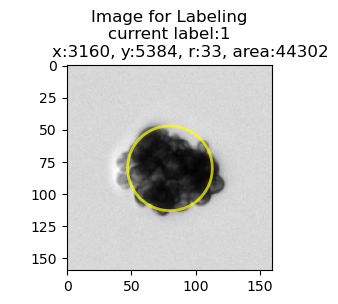

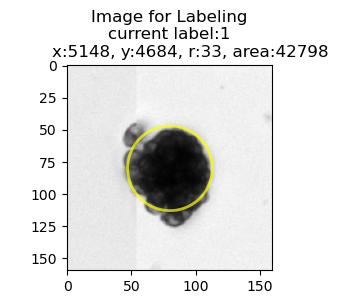

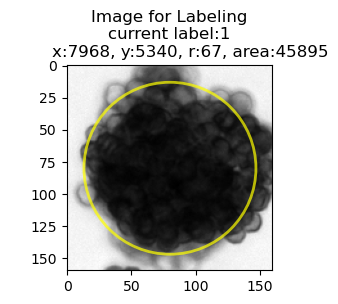

In [20]:
## labeled as YES
_ = show_rand_crops(crops=labeled, label_filter=1, num_shown=3)

Samples of 2 blobs will be plotted


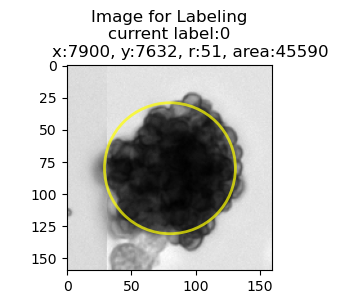

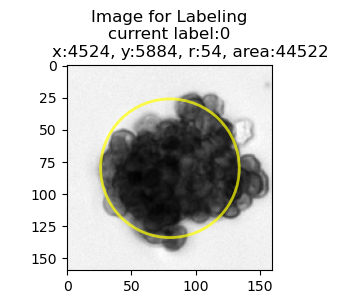

In [21]:
## labeled as NO
_ = show_rand_crops(crops=labeled, label_filter=0, num_shown=2)

Samples of 1 blobs will be plotted


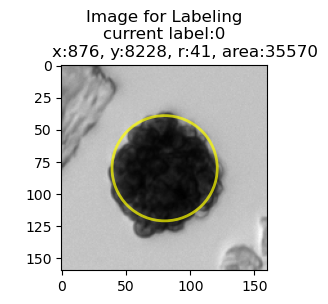

In [55]:
# any label (Optional)
_ = show_rand_crops(crops=labeled, label_filter='na', num_shown=1)

## Unsupervised classification (overview of blobs) (Optional)

In [23]:
crops_stat(crops)

5 Yes, 30 No, 0 Uncertain, 0 Unlabeled
Total: 35


dim before PCA (35, 40006)
dim after PCA (35, 35)
explained variance ratio: 1.0
matched cluster_info: (35,)
unmatched data will be excluded from the plot
all labels: ['0' '1']


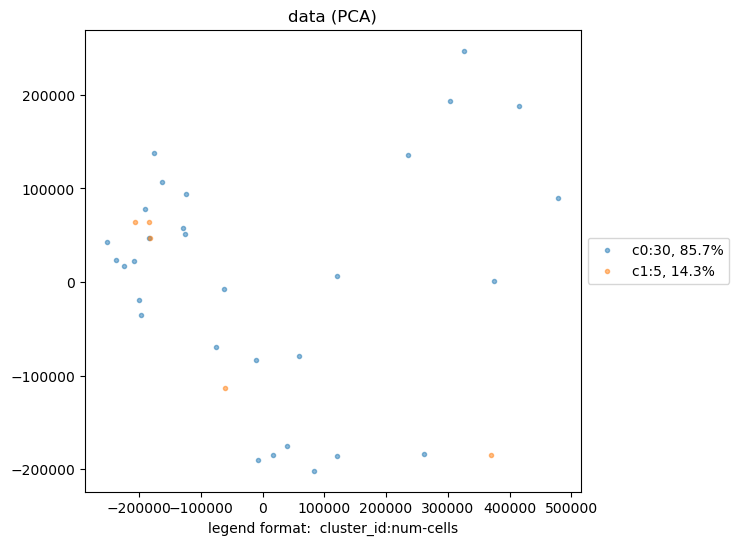

took 0.3 seconds



In [24]:
cluster_info = pd.DataFrame(crops[:, 3], columns=['cluster_id'])
tsne_df = pca_tsne(pd.DataFrame(crops), cluster_info=cluster_info)

# Save notebook for review

In [25]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [26]:
!jupyter nbconvert --to html labeling.ipynb

[NbConvertApp] Converting notebook labeling.ipynb to html
[NbConvertApp] Writing 1684071 bytes to labeling.html


In [27]:
nb_name = name + '.labeling.ipynb'
html_name = name + ".labeling.html"
!echo $html_name $nb_name
!cp labeling.ipynb $nb_name
!mv labeling.html $html_name

S0A1_FIRST_SCAN-Stitching-24.2.labeling.html S0A1_FIRST_SCAN-Stitching-24.2.labeling.ipynb
